# Homework 3 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Функция для классификации изображения как леса или пустыни

In [2]:
def detect_forest_desert(img_path):
    img= cv2.imread(img_path)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    f_mask = cv2.inRange(img_hsv, np.array([35, 25, 25]), np.array([85, 255, 255]))
    d_mask = cv2.inRange(img_hsv, np.array([15, 25, 25]), np.array([35, 255, 255]))
    f_pixels = cv2.countNonZero(f_mask)
    d_pixels = cv2.countNonZero(d_mask)
    label = 'Desert'
    if f_pixels > d_pixels:
        label = 'Forest'
    return img, f_mask, d_mask, label

Возьмем для тестирования функции выше две картинки: на одной будет лес, на другой - пустыня.

Лес:

Detected Forest on image desert_forest/test_image_09.jpg


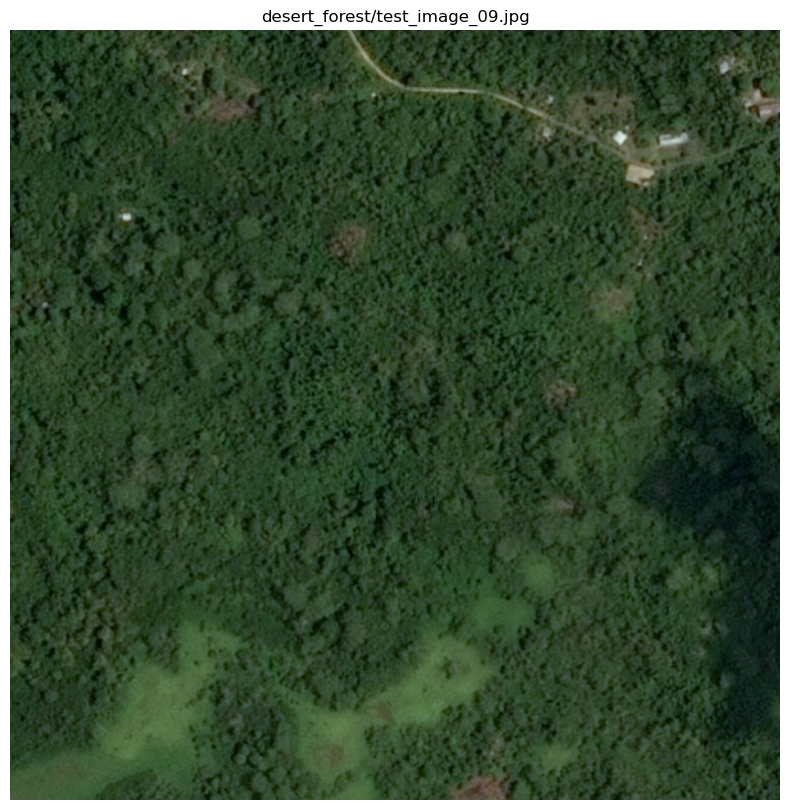

In [3]:
path_f = 'desert_forest/test_image_09.jpg'
image_f, f_mask_f, d_mask_f, label_f = detect_forest_desert(path_f)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_f, cv2.COLOR_BGR2RGB))
plt.title(path_f)
plt.axis('off')
print(f"Detected {label_f} on image {path_f}")

Пустыня:

Classification: Desert


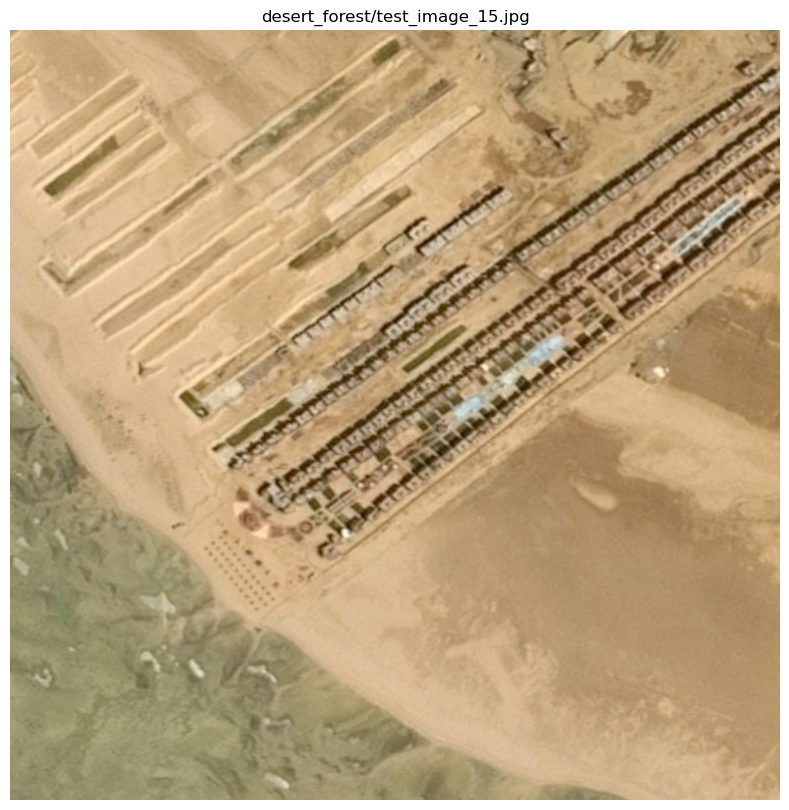

In [4]:
path_d = 'desert_forest/test_image_15.jpg'
image_d, f_mask_d, d_mask_d, label_d = detect_forest_desert(path_d)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_d, cv2.COLOR_BGR2RGB))
plt.title(path_d)
plt.axis('off')
print(f"Classification: {label_d}")

In [5]:
def plot(image, forest_mask, desert_mask, classification, title):
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Classification: {classification}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(forest_mask, cmap='gray')
    plt.title('Forest Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(desert_mask, cmap='gray')
    plt.title('Desert Mask')
    plt.axis('off')
    plt.show()

Напишем функцию для отображения масок для леса и пустыни и результата классификации.

Посмотрим, что получилось

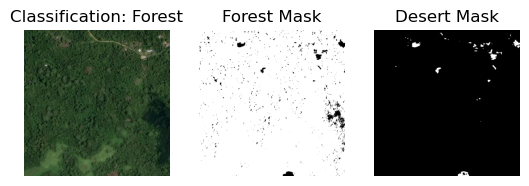

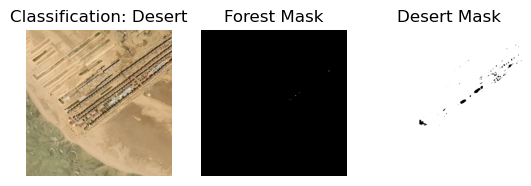

In [6]:
plot(image_f, f_mask_f, d_mask_f, label_f, path_f)
plot(image_d, f_mask_d, d_mask_d, label_d, path_d)

# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="./blending/blending.png" alt="Drawing" style="width: 700px;"/>


Загрузим предобученные каскады Хаара

In [20]:
face_cascade = cv2.CascadeClassifier('./haar/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haar/haarcascade_eye.xml')
nose_cascade = cv2.CascadeClassifier('./haar/haarcascade_mcs_nose.xml')  
mouth_cascade = cv2.CascadeClassifier('./haar/haarcascade_mcs_mouth.xml')  

Функции для детекции частей лица, метода Seamless Cloning и отображения Source Image, Destination Image и результата применения метода Seamless Cloning.

In [21]:
def haar_detection(path, f_cas, e_cas, n_cas, m_cas):
    image = cv2.imread(path)
    if image is None:
        raise ValueError(f"Ошибка загрузки изображения по пути {path}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = f_cas.detectMultiScale(gray, 1.3, 5)
    mask = np.zeros_like(gray)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = e_cas.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.ellipse(mask, ((ex + ew//2 + x), (ey + eh//2 + y)), (ew//2, eh//2), 0, 0, 360, 255, -1)
        nose = n_cas.detectMultiScale(roi_gray)
        for (nx, ny, nw, nh) in nose:
            cv2.ellipse(mask, ((nx + nw//2 + x), (ny + nh//2 + y)), (nw//2, nh//2), 0, 0, 360, 255, -1)
        mouth = m_cas.detectMultiScale(roi_gray)
        for (mx, my, mw, mh) in mouth:
            cv2.ellipse(mask, ((mx + mw//2 + x), (my + mh//2 + y)), (mw//2, mh//2), 0, 0, 360, 255, -1)

    return image, mask

In [22]:
def seamless_cloning(src, src_mask, dst):
    height = dst.shape[0]
    width = dst.shape[1]
    src_resized = cv2.resize(src, (width, height))
    src_mask_resized = cv2.resize(src_mask, (width, height))
    center = (width // 2, height // 2)
    return cv2.seamlessClone(src_resized, dst, src_mask_resized, center, cv2.NORMAL_CLONE)

In [23]:
def plot_seamless(src, dst, seamless_image):
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
    plt.title('Source Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    plt.title('Destination Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(seamless_image, cv2.COLOR_BGR2RGB))
    plt.title('Seamless Cloned Image')
    plt.axis('off')
    plt.show()

Загрузим изображения и маски. Я взял свое изображение и изображение девушки из интернета.

In [24]:
src_path = "./faces/woman.jpg"
dst_path = "./faces/man.jpg"

src_img, src_mask = haar_detection(src_path, face_cascade, eye_cascade, nose_cascade, mouth_cascade)
dst_img, _ = haar_detection(dst_path, face_cascade, eye_cascade, nose_cascade, mouth_cascade)

Применим метод Seamless Cloning и отобразим результаты

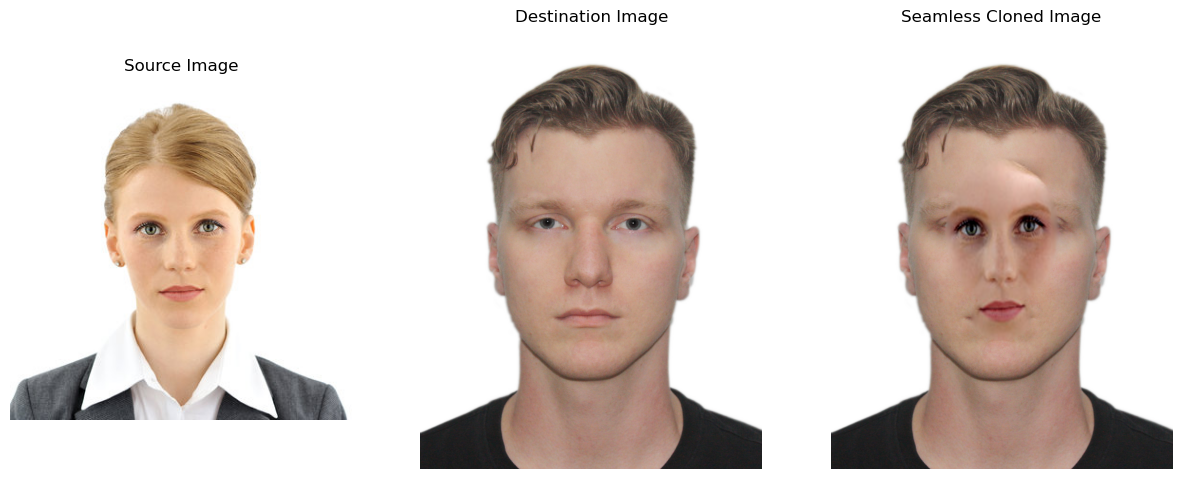

In [25]:
seamless_image = seamless_cloning(src_img, src_mask, dst_img)

plot_seamless(src_img, dst_img, seamless_image)

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="./cells/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

__Ответ__: 
1. Изучить размеры изображений, чтобы выбрать подходящий размер ячейки, в зависимости от особенностей данных.
2. Проанализировать среднее количество ячеек с клетками для каждой картинки и установить это значение для параметра cell_count, что поможет лучше адаптировать модель к различным изображениям.
3. Настроить порог фильтрации пустых областей, используя методы экспериментов или кластеризации пикселей, чтобы улучшить качество обработки изображений.
4. Провести тестирование на небольшом подмножестве изображений, подбирая значения параметров вручную, что позволит выявить наиболее эффективные настройки.
5. Использовать обратную связь от модели классификации для дальнейшего уточнения параметров, что поможет повысить точность и эффективность модели.

Дополнительно, можно рассмотреть возможность применения автоматизированных методов оптимизации, таких как генетические алгоритмы или методы градиентного спуска, чтобы ускорить процесс подбора параметров и улучшить результаты.

Посмотрим на один из снимков раковых клеток

(-0.5, 1367.5, 7199.5, -0.5)

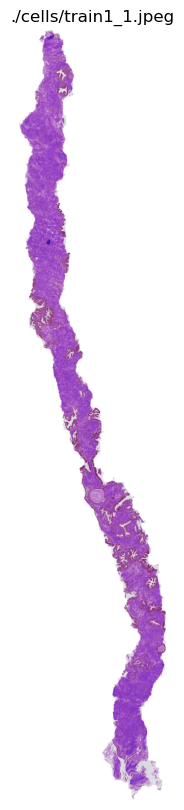

In [26]:
image = Image.open('./cells/train1_1.jpeg')
image_np = np.array(image)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.title('./cells/train1_1.jpeg')
plt.axis('off')


Определим размер клеток, их количество, а также пэддинг для подготовки мозаики.

In [27]:
cell_size = 256
cell_count = 64
padding = 10

cells = []
extracted_cells = 0

Отобразим изображение с выделенными ячейками

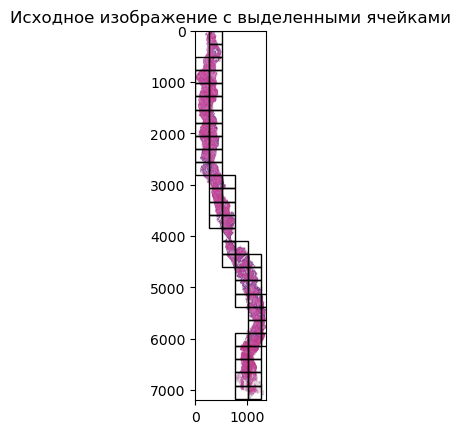

In [28]:
fig, ax = plt.subplots(1)

ax.imshow(image_np)
for y in range(0, image_np.shape[0], cell_size):
    for x in range(0, image_np.shape[1], cell_size):
        if extracted_cells >= cell_count:
            break
        cell = image_np[y:y + cell_size, x:x + cell_size]
        if cell.mean() < 240:
            cells.append(cell)
            extracted_cells += 1
            rect = patches.Rectangle((x, y), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

plt.title("Исходное изображение с выделенными ячейками")
plt.show()

Создадим мозаику и отобразим её.

In [29]:
if len(cells) > 16:
    cells = cells[:16]
elif len(cells) < 16:
    cells = cells * (16 // len(cells)) + cells[:16 % len(cells)]
grid_size = 4
mosaic_size = grid_size * cell_size + (grid_size - 1) * padding
mosaic = np.ones((mosaic_size, mosaic_size, 3), dtype=np.uint8) * 255

for idx, cell in enumerate(cells):
    i = idx // grid_size
    j = idx % grid_size
    y_start = i * (cell_size + padding)
    x_start = j * (cell_size + padding)
    mosaic[y_start:y_start + cell_size, x_start:x_start + cell_size] = cell

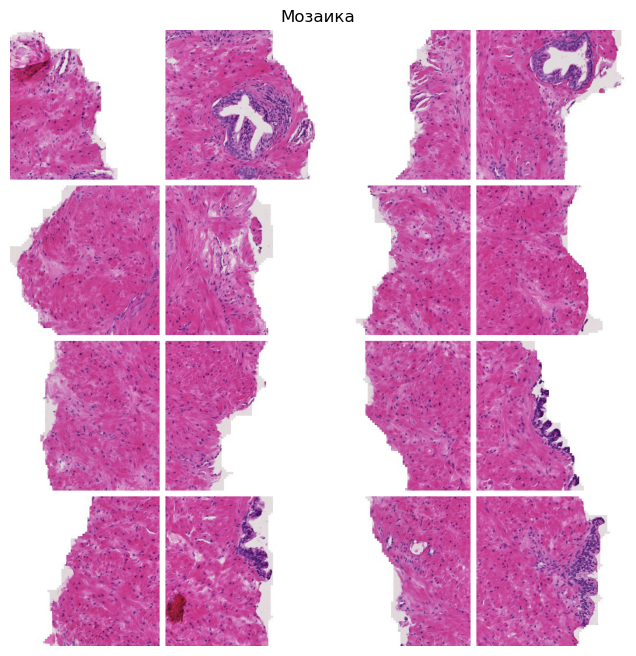

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(mosaic)
plt.axis('off')
plt.title("Мозаика")
plt.show()